In [7]:
import pickle
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.metrics import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

DATA_PATH = "./cifar-10-batches-py/"
data_augmentation = False
modelName = "linear"

In [8]:
def unpickle(file): # fonction pour load des files
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [13]:
def show_first_samples(x_train, y_train, labels_name):
    
    for i in range(4):
        imgs = x_train[i]
        imgR = imgs[0]
        imgG = imgs[1]
        imgB = imgs[2]
        i0 = Image.fromarray(imgR)
        i1 = Image.fromarray(imgG)
        i2 = Image.fromarray(imgB)
        img = Image.merge("RGB",(i0,i1,i2)) #merge les image red, green, blue en meme l'image
        plt.imshow(img)
        print(labels_name[y_train[i]])
        plt.show()

In [14]:
def load_data():
    data_first = unpickle(DATA_PATH + "data_batch_1")
    data_x = data_first[b'data']
    data_y = data_first[b'labels']
    for i in range(2,6):
        data = unpickle(DATA_PATH + f"data_batch_{i}")
        data_x = np.vstack((data_x, data[b'data']))
        data_y += data[b'labels']
    return data_x, data_y

In [15]:
def create_model():
    model = Sequential()

    model.add(Dense(3072, input_shape=(3072,)))# input shape est 32 * 32 * 3, images 32 * 32 et c'est image RGB
    model.add(Activation('relu')) #c'est le fonction avtivite le plus frequence. 

    model.add(Dense(10)) #il y a 10 class pour ce dataset, donc la parametre de le dernier courche de dense est 10.
    model.add(Activation('softmax')) #toujour utiliser ce fonction activiter pour la case classification

    model.compile(loss = sparse_categorical_crossentropy,#tourjour utiliser pour la case classification
                  optimizer=Adam(),#
                  metrics=['accuracy'])
    
    return model

b'frog'


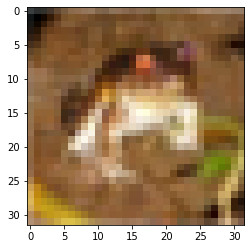

b'truck'


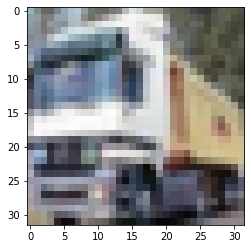

b'truck'


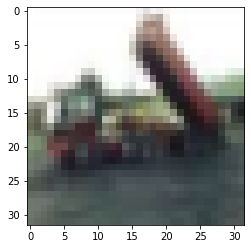

b'deer'


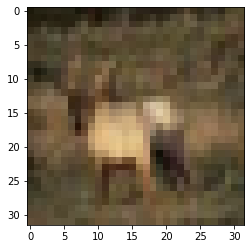

In [16]:
x_train, y_train = load_data() #load the train data cifar

data_test = unpickle(DATA_PATH + "test_batch") # load the test data
x_val, y_val = data_test[b'data'], data_test[b'labels'] 

data_info = unpickle(DATA_PATH + "batches.meta") #load the data infos 
labels_name = data_info[b'label_names'] #load the labels name, il peux tranfer le target au le descript de type

x_image = x_train.reshape(-1, 3, 32, 32)
    
y_train = np.array(y_train) #transfer des array au np.array
y_val = np.array(y_val)

show_first_samples(x_image, y_train, labels_name)

In [17]:
x_train = x_train / 255.0 #transfer les data au float
x_val = x_val / 255.0

In [18]:
model = create_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 3072)              9440256   
_________________________________________________________________
activation (Activation)      (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                30730     
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 9,470,986
Trainable params: 9,470,986
Non-trainable params: 0
_________________________________________________________________
None


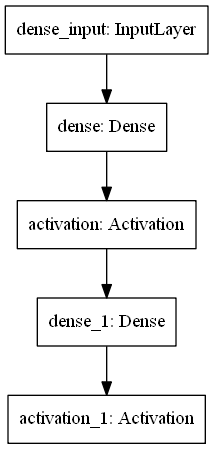

In [19]:
plot_model(model, f"{modelName}_log/{modelName}.png")

In [20]:
if data_augmentation: # data_augumentation
        aug = ImageDataGenerator(width_shift_range = 0.2, height_shift_range = 0.2, horizontal_flip = True) #la fonction pour data aurgumenter.
        aug.fit(x_train)
        gen = aug.flow(x_train, y_train, batch_size=128)
        history = model.fit_generator(generator=gen, 
                                 steps_per_epoch=50000/128, 
                                 epochs=30, 
                                 validation_data=(x_val, y_val),
                                 callbacks=[
                                    EarlyStopping(monitor="val_accuracy", patience=2),
                                    TensorBoard(log_dir=f"{modelName}_log", histogram_freq=1)
                                    ])
else:
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
            epochs=30,
            batch_size=128,
            callbacks=[
                EarlyStopping(monitor="val_accuracy", patience=2), #si acc n'ai pas augumenter depluis deux epoches, arreter le processe
                TensorBoard(log_dir=f"{modelName}_log", histogram_freq=1)
                ])

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 11s 227us/sample - loss: 2.2330 - accuracy: 0.3144 - val_loss: 1.7741 - val_accuracy: 0.3715
Epoch 2/30
50000/50000 [==============================] - 10s 203us/sample - loss: 1.7125 - accuracy: 0.3938 - val_loss: 1.6410 - val_accuracy: 0.4138
Epoch 3/30
50000/50000 [==============================] - 11s 210us/sample - loss: 1.6255 - accuracy: 0.4233 - val_loss: 1.5961 - val_accuracy: 0.4376
Epoch 4/30
50000/50000 [==============================] - 11s 221us/sample - loss: 1.5828 - accuracy: 0.4389 - val_loss: 1.6074 - val_accuracy: 0.4226
Epoch 5/30
50000/50000 [==============================] - 12s 242us/sample - loss: 1.5408 - accuracy: 0.4539 - val_loss: 1.5376 - val_accuracy: 0.4581
Epoch 6/30
50000/50000 [==============================] - 14s 279us/sample - loss: 1.5087 - accuracy: 0.4665 - val_loss: 1.5346 - val_accuracy: 0.4549
Epoch 7/30
50000/50000 [====================

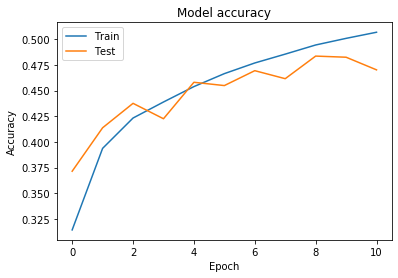

In [21]:
plt.plot(history.history['accuracy']) #enregister les resultat au image
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(f'./{modelName}_log/{modelName}_accuracy.png')
plt.show()

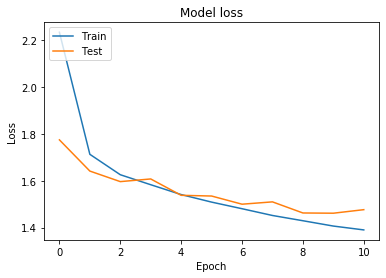

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(f'./{modelName}_log/{modelName}_loss.png')
plt.show()